In [1]:
import cv2
import numpy as np
import os
from kneed import KneeLocator
import matplotlib.pyplot as plt

def cartoonify_image(filename):
    # takes input image as parameter
    image = cv2.imread(filename)
    # changing the size of image
    image = cv2.resize(image, [525,335])
 
    #converting image into numpy 3D array
    output=np.array(image)
    x,y,c=output.shape
    # filtering(smoothing/denoising) colour image seperately for each channel(Blue, Green, Red)
    for i in range(c):
        output[:,:,i]=cv2.bilateralFilter(output[:,:,i],5,150,150)
    # detecting edges by using Canny edge detection
    edge=cv2.Canny(output, 100, 200)
    #for converting the colour from BGR to HSV(hue, saturation, value)
    output=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    #converting 3D array into 2D array
    Z = output.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    
    #setting the criteria for kmeans clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    #creating array in range 2,13
    kvals = np.arange(2, 10)
    compactness = []
    #calculating  compactness for no of clusters in range 2,13
    for k in kvals:
        c,_,_=cv2.kmeans(Z,k,None,criteria,10,cv2.KMEANS_PP_CENTERS)
        compactness.append(c)

    #plotting graph for finding elbow
    plt.figure(figsize=(10, 6))
    plt.plot(kvals, compactness, 'o-', linewidth=4, markersize=12);
    plt.xlabel('number of clusters')
    plt.ylabel('compactness/SSD')

    #locating knee/elbow from graph(convex for elbow)
    kn = KneeLocator(kvals, compactness, curve='convex', direction='decreasing')
    #kn.elbow value is used as no of clusters
    K = kn.elbow
    #calculating kmeans for K no of clusters
    c,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_PP_CENTERS)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((output.shape))
    #converting back into BGR
    res2=cv2.cvtColor(res2, cv2.COLOR_HSV2BGR)
    #finding shape and outline of image by using the edges
    contours,_=cv2.findContours(edge,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    #then drawing those countours on output image
    cv2.drawContours(res2,contours,-1,0,thickness=1)
    
    (dirname,filename1) =os.path.split(filename)
    cv2.imwrite(f"cartonified_images/cartoonified_{filename1}", res2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return f"cartonified_images/cartoonified_{filename1}"

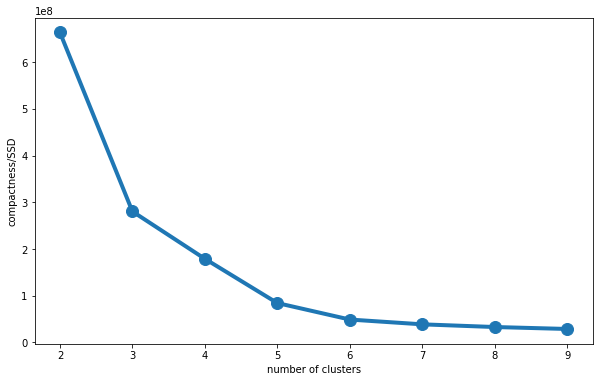

In [19]:
from tkinter import *
from PIL import Image, ImageTk
from tkinter.filedialog import askopenfilename

#creating gui
root = Tk()
#place GUI at x=50, y=10
root.geometry('+%d+%d'%(50,10)) 

root.title('Cartoonify')

#header area for logo & browse button
header = Frame(root, width=1200, height=175, bg="white")
header.grid(columnspan=3, rowspan=2, row=0)

#content area for text and image display
content = Frame(root, width=1200, height=450, bg="#20bebe")
content.grid(columnspan=3, rowspan=2, row=2)

def open_file():
    #For chainging text of button
    browse_text.set("loading...")
    # Browseing for image
    filename = askopenfilename(filetype=[('Image File', ['*.jpg', '*.png', '*.jpeg'])])
    # checking image is selected or not
    if filename=="":
        inste = Label(root, text="You Have To Select a Image file!!", font=("Raleway", 10), bg="white")
        inste.grid(column=1, row=0, sticky=SE, padx=75, pady=5)
        browse_text.set("Browse")
        #reseting content
        content = Frame(root, width=1200, height=450, bg="#20bebe")
        content.grid(columnspan=3, rowspan=2, row=2)
        return
    #reseting content
    content = Frame(root, width=1200, height=450, bg="#20bebe")
    content.grid(columnspan=3, rowspan=2, row=2)
    # loading the image
    image1 = Image.open(filename)
    image1= image1.resize((525,335), Image.ANTIALIAS)
    img = ImageTk.PhotoImage(image1)
    #Creating Label For Heading
    inst = Label(root, text="Original Image", font=("Raleway", 20), fg="#FFFFFF", bg="#20bebe")
    inst.place(relx=0.17, rely=0.30)
    #Creating Label For Showing Original Image
    label1 = Label(image=img)
    label1.image = img
    label1.place(relx=0.03, rely=0.37)
    #creating button to call output_image function
    cartonify_btn = Button(root, text="Cartonify", command=lambda:output_image(filename,cartonify_btn), font=("Raleway",12), bg="#20bebe", fg="white", height=1, width=15)
    cartonify_btn.place(relx=0.17, rely=0.93)
    
def output_image(filename,cartoonify_btn):
    
    #Calling function For Cartonifing Image
    output_path=cartoonify_image(filename)
    
    #Creating Label For Heading For Cartonified Image
    inst2= Label(root, text="Cartoonized Image", font=("Raleway", 20), fg="#FFFFFF", bg="#20bebe")
    inst2.place(relx=0.65, rely=0.30)
    
    # loading the cartonified image
    image2 = Image.open(output_path)
    image2= image2.resize((525,335), Image.ANTIALIAS)
    img2 = ImageTk.PhotoImage(image2)
    #Creating Label For Showing Cartonified Image
    label2 = Label(image=img2)
    label2.image = img2
    label2.place(relx=0.52, rely=0.37)
    
    # desroying btn
    cartoonify_btn.destroy()
    #For chainging text of button
    browse_text.set("Browse")

# loading the Logo image
image1 = Image.open(f"logo.png")
img = ImageTk.PhotoImage(image1)
label1 = Label(image=img)
label1.image = img
label1.place(relx=0.02, rely=0.02)

#lable for displaying text-> Select a Image file
inst = Label(root, text="Select a Image file", font=("Raleway", 10), bg="white")
inst.grid(column=1, row=0, sticky=SE, padx=75, pady=5)

#browse button
browse_text = StringVar()
browse_btn = Button(root, textvariable=browse_text, command=lambda:open_file(), font=("Raleway",12), bg="#20bebe", fg="white", height=1, width=15)
browse_text.set("Browse")
browse_btn.grid(column=1, row=1, sticky=NE, padx=50)

root.mainloop()

In [ ]:
## For Converting .ipynb file to .exe ---For Windows
#ipython nbconvert --to script cartoonify.ipynb
#pyinstaller --onefile --windowed cartoonify.py